## CEAL: Cost-Effective Active Learning for Deep Image Classification

In [1]:
import numpy as np
import torch
from torchvision import datasets

import random, os

random_seed= 42
model_random_seed=42
random.seed(random_seed)
np.random.seed(random_seed)
os.environ["PYTHONHASHSEED"] = str(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(False)

## 데이터 분할

In [2]:
import pandas as pd
def get_train_data_list(root):
    x = list()
    y = list()
    i = 0
    data_dir = os.path.join(root, "train")
    for cls in sorted(os.listdir(data_dir)):
        cls_dir = os.path.join(data_dir, cls)  # 각 클래스의 이미지들이 들어있는 경로
        imgs = os.listdir(cls_dir)  # 각 이미지의 이름
        imgs = [os.path.join(cls_dir, img) for img in imgs]  # 이미지의 이름을 경로로 변환
        x += imgs  # 해당 클래스의 이미지들을 저장
        y += [i] * len(imgs)  # 추가한 이미지들의 라벨 추가
        i += 1
    return np.array(x), np.array(y)
def get_test_data_list(root):
    data_dir = os.path.join(root, "test")
    x = [os.path.join(data_dir, img) for img in sorted(os.listdir(data_dir))]
    y = pd.read_csv(os.path.join(root, "y_test.csv"))["Label"]
    return np.array(x), np.array(y).reshape(-1)

In [3]:
from PIL import Image  # 이미지를 읽어오기 위한 라이브러리

# CUB200 커스텀 데이터셋 정의
class CUB200(torch.utils.data.Dataset):
    def __init__(self, x, y, transform=None):
        self.transform = transform
        self.x = x  # 이미지들의 경로를 담은 리스트
        self.y = y  # 라벨을 담은 리스트

        self.x = np.array(self.x)
        self.y = np.array(self.y)

    def __getitem__(self, idx):
        img = self.x[idx]  # 읽어올 이미지의 경로
        img = Image.open(img)  # 이미지 읽어오기
        if self.transform:
            img = self.transform(img)
        return img, self.y[idx]

    def __len__(self):
        return self.x.shape[0]

In [4]:
from torchvision.transforms import ToTensor, Resize, InterpolationMode, Compose
transform = Compose([
    ToTensor(),  # PIL.Image를 torch.Tensor로 변환하고, 255를 나눠 scale 조정
    Resize((224, 224), interpolation=InterpolationMode.NEAREST)  # 이미지를 224x224의 고정된 크기로 변환
])
train_x, train_y = get_train_data_list("./data/CUB200")
test_x, test_y = get_test_data_list("./data/CUB200")
print(len(train_x))
print(len(test_x))

598
569


### 신경망 모델 학습

In [5]:
from model import CNN_CUB as CNN
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, TensorDataset

In [6]:
def train_model(model, total_iter, train_dataloader, test_dataloader):
    loss_fn = CrossEntropyLoss().cuda()
    optimizer = Adam(model.parameters(), lr=2e-5)
    model.train()
    it = 0
    loss=0
    while True:
        for x_batch, y_batch in train_dataloader:
            if it > total_iter:
                break
            x_batch = x_batch.cuda()
            y_batch = y_batch.cuda()

            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)

            optimizer.zero_grad()  # 옵티마이저 초기화
            loss.backward()  # 오차 역전파
            optimizer.step()  # 역전파된 오차를 이용한 파라미터 업데이트 수행
            it += 1
            
            if it%10==0:
                loss_epoch = 0
                accuracy_epoch = 0
                model.eval()  # 모델을 테스트 모드로 설정
                for x_batch, y_batch in test_dataloader:
                    x_batch = x_batch.cuda()
                    y_batch = y_batch.cuda()

                    with torch.no_grad():  # 테스트 간 그래디언트 계산 중지
                        pred = model(x_batch)
                        loss = loss_fn(pred, y_batch)
                    
                    loss_epoch += loss.item()
                    accuracy_epoch += torch.sum(torch.argmax(pred, dim=1) == y_batch).item()

                loss_epoch /= len(test_dataloader.dataset)
                accuracy_epoch /= len(test_dataloader.dataset)
                print(f"it: {it}\ttrain_loss: {loss.item()}\ttest_loss: {loss_epoch}\ttest_acc: {accuracy_epoch}")

        
        if it > total_iter:
            break

    loss_epoch = 0
    accuracy_epoch = 0
    model.eval()  # 모델을 테스트 모드로 설정
    for x_batch, y_batch in test_dataloader:
        x_batch = x_batch.cuda()
        y_batch = y_batch.cuda()

        with torch.no_grad():  # 테스트 간 그래디언트 계산 중지
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
        
        loss_epoch += loss.item()
        accuracy_epoch += torch.sum(torch.argmax(pred, dim=1) == y_batch).item()

    loss_epoch /= len(test_dataloader.dataset)
    accuracy_epoch /= len(test_dataloader.dataset)

    return loss_epoch, accuracy_epoch

## CEAL

In [7]:
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from tqdm import tqdm

test_dataset = CUB200(test_x, test_y, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, drop_last=False, num_workers=16)

def run_test(K=3000, delta_0=-1, dr=0.0033, total_iter=3000, mode="LC"):
    x_train_init, x_train_unlabeled, y_train_init, y_train_unlabeled = train_test_split(train_x, train_y, train_size=64, random_state=random_seed, shuffle=True)

    # print(x_train_init.shape)
    # print(x_train_unlabeled.shape)

    T = len(x_train_unlabeled) // K  + 1  # 데이터를 추가해나가며 수행할 iteration cycle 수
    # 데이터를 배치 단위로 불러오기 위한 데이터로더 정의
    x_labeled = x_train_init
    y_labeled = y_train_init

    train_dataset = CUB200(x_labeled, y_labeled, transform=transform)
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True, num_workers=16)

    val_acc_hist = list()

    model = None
    for t in tqdm(range(T)):
        if t != 0: # 첫 iteration에서는 데이터 추가하지 않음
            model.eval()
            unlabeled_dataloader = DataLoader(CUB200(x_train_unlabeled, y_train_unlabeled, transform=transform), batch_size=1024, shuffle=False, drop_last=False)
            preds = list()
            for x_batch, _ in unlabeled_dataloader:
                x_batch = x_batch.cuda()
                with torch.no_grad():
                    pred = F.softmax(model(x_batch))
                preds.append(pred)
            preds = torch.cat(preds, 0)

            ranking = torch.zeros(preds.shape[0], 3)

            # Least Confidence
            top1_acc = preds.max(1)[0]
            _, indices = top1_acc.sort()
            indices_LC = indices[:K]
            for i in range(len(preds)):
                ranking[i][0] = torch.where(indices==i)[0]

            # Margin Sampling
            _, indices = torch.topk(preds, k=2, dim=1, largest=True)
            top2_acc = torch.gather(preds, 1, indices[:, 1].unsqueeze(1))
            top2_acc = top2_acc[:, 0]
            margins = top1_acc - top2_acc
            _, indices = margins.sort()
            indices_MS = indices[:K]
            for i in range(len(preds)):
                ranking[i][1] = torch.where(indices==i)[0]

            # Entropy
            entropy = -torch.sum(preds * torch.log(preds), 1)
            _, indices = entropy.sort(descending=True)
            indices_EN = indices[:K]
            for i in range(len(preds)):
                ranking[i][2] = torch.where(indices==i)[0]

            _, indices = ranking.mean(1).sort()
            indices_FUSION = indices[:K]

            # 랜덤
            indices_RN = torch.randperm(len(preds))[:K]

            # 라벨링
            if mode == "LC": indices = indices_LC
            elif mode == "MS": indices = indices_MS
            elif mode == "EN": indices = indices_EN
            elif mode == "FUSION": indices = indices_FUSION
            else: 
                indices = indices_RN
                delta_0 = -1  # Disable pseudo labelling
            x_new = x_train_unlabeled[indices.cpu()]
            y_new = y_train_unlabeled[indices.cpu()]

            mask = torch.ones(x_train_unlabeled.shape[0], dtype=torch.bool)
            mask[indices] = 0
        
            # K개의 새로운 라벨링 데이터를 추가
            x_labeled = np.concatenate([x_labeled, x_new], 0)
            y_labeled = np.concatenate([y_labeled, y_new], 0)
            
            # high confidence samples H
            # Update delta
            delta = delta_0 - dr * t
            indices = entropy < delta
            if indices.sum() != 0:
                x_h = x_train_unlabeled[indices.cpu()]
                y_h = preds.argmax(1)[indices.cpu()].cpu()
                x_train = np.concatenate([x_labeled, x_h], 0)
                y_train = np.concatenate([y_labeled, y_h], 0)
            else:
                x_train = x_labeled
                y_train = y_labeled

            # 라벨링된 데이터는 제외
            x_train_unlabeled = x_train_unlabeled[mask]
            y_train_unlabeled = y_train_unlabeled[mask]

            # labeled data + H
            train_dataset = CUB200(x_train, y_train, transform=transform)
            train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True, num_workers=16)
        
        model = CNN(random_state=model_random_seed).cuda()
        loss, acc = train_model(model, total_iter, train_dataloader, test_dataloader)
        val_acc_hist.append(acc)

    return np.array(val_acc_hist)

/usr/local/envs/giopaik_def/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


In [8]:
acc_hist_FUSION = run_test(K=64, delta_0=0.05, dr=0.0033, total_iter=150, mode="FUSION")
acc_hist_LC = run_test(K=64, delta_0=0.05, dr=0.0033, total_iter=150, mode="LC")
acc_hist_MS = run_test(K=64, delta_0=0.05, dr=0.0033, total_iter=150, mode="MS")
acc_hist_EN = run_test(K=64, delta_0=0.05, dr=0.0033, total_iter=150, mode="EN")
acc_hist_RN = run_test(K=64, delta_0=0.05, dr=0.0033, total_iter=150, mode="RN")

baseline = np.stack([acc_hist_EN, acc_hist_MS, acc_hist_LC, acc_hist_RN, acc_hist_FUSION])[:, -1].max()
# Baseline
# model = CNN(random_state=random_seed).cuda()
# x_train = torch.FloatTensor(CIFAR_TRAIN.data).permute(0, 3, 1, 2) / 255.
# y_train = torch.LongTensor(np.array(CIFAR_TRAIN.targets))

# train_dataset = TensorDataset(x_train, y_train)
# train_dataloader = DataLoader(train_dataset, batch_size=512, shuffle=True, drop_last=True)
# loss, acc = train_model(model, 3000, train_dataloader, test_dataloader)
# baseline = acc

/usr/local/envs/giopaik_def/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
  0%|          | 0/9 [00:00<?, ?it/s]

it: 10	train_loss: 3.036485195159912	test_loss: 0.005336529341230074	test_acc: 0.08084358523725835
it: 20	train_loss: 2.902981758117676	test_loss: 0.005101901156621574	test_acc: 0.10896309314586995
it: 30	train_loss: 2.836634397506714	test_loss: 0.004985297710908109	test_acc: 0.17750439367311072
it: 40	train_loss: 3.0058727264404297	test_loss: 0.005282728868963848	test_acc: 0.18980667838312829
it: 50	train_loss: 3.285292387008667	test_loss: 0.00577380032866198	test_acc: 0.20738137082601055
it: 60	train_loss: 3.4333620071411133	test_loss: 0.006034028132058195	test_acc: 0.1968365553602812
it: 70	train_loss: 3.511094808578491	test_loss: 0.0061706411398567505	test_acc: 0.19332161687170474
it: 80	train_loss: 3.5522336959838867	test_loss: 0.00624294146921597	test_acc: 0.19507908611599298
it: 90	train_loss: 3.5762972831726074	test_loss: 0.0062852324836073946	test_acc: 0.18980667838312829
it: 100	train_loss: 3.5920403003692627	test_loss: 0.006312900352142816	test_acc: 0.19156414762741653
it: 1

 11%|█         | 1/9 [03:24<27:16, 204.57s/it]/home/giopaik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


it: 10	train_loss: 3.017076253890991	test_loss: 0.005302418723885749	test_acc: 0.09314586994727592
it: 20	train_loss: 2.806769609451294	test_loss: 0.004932811264413522	test_acc: 0.14938488576449913
it: 30	train_loss: 2.723052740097046	test_loss: 0.004785681441295335	test_acc: 0.210896309314587
it: 40	train_loss: 2.59594988822937	test_loss: 0.004562302088276573	test_acc: 0.28471001757469244
it: 50	train_loss: 2.7164275646209717	test_loss: 0.004774037899158122	test_acc: 0.3093145869947276


### 정확도 그래프

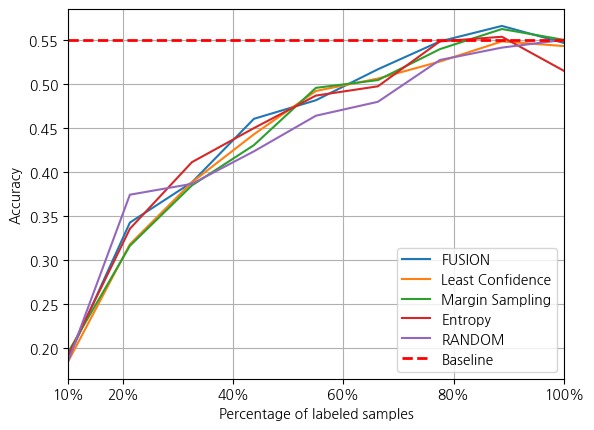

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

interval = 11.25
plt.plot(np.arange(10, 101, interval), acc_hist_FUSION, label="FUSION")
plt.plot(np.arange(10, 101, interval), acc_hist_LC, label="Least Confidence")
plt.plot(np.arange(10, 101, interval), acc_hist_MS, label="Margin Sampling")
plt.plot(np.arange(10, 101, interval), acc_hist_EN, label="Entropy")
plt.plot(np.arange(10, 101, interval), acc_hist_RN, label="RANDOM")
plt.hlines(y=baseline, xmin=10, xmax=100, label="Baseline", linestyles="--", linewidth=2, color="red")
tick = [10]+list(np.arange(20, 101, 20))
plt.xticks(tick)
ax.set_xticklabels([str(t)+"%" for t in tick])
plt.margins(x=0)

# plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Percentage of labeled samples")

# plt.legend(["Least Confidence", "Margin Sampling", "Entropy", "RANDOM", "Baseline"], loc="best")
plt.legend()
plt.grid()
plt.show()

/usr/local/envs/giopaik_def/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
100%|██████████| 16/16 [18:59<00:00, 71.20s/it]


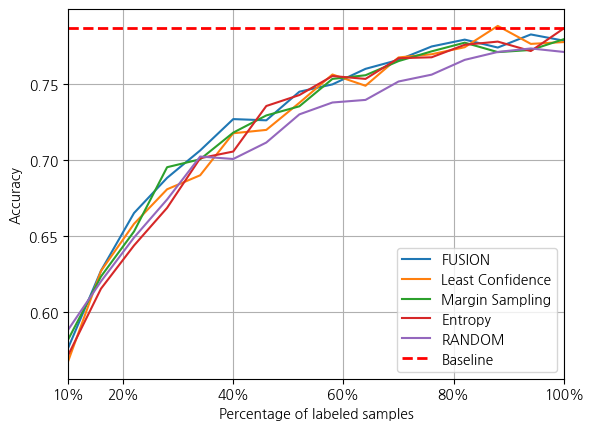

In [ ]:
acc_hist_FUSION = run_test(K=3000, delta_0=-1, dr=0.0033, total_iter=3000, mode="FUSION")
acc_hist_LC = run_test(K=3000, delta_0=-1, dr=0.0033, total_iter=3000, mode="LC")
acc_hist_MS = run_test(K=3000, delta_0=-1, dr=0.0033, total_iter=3000, mode="MS")
acc_hist_EN = run_test(K=3000, delta_0=-1, dr=0.0033, total_iter=3000, mode="EN")
acc_hist_RN = run_test(K=3000, delta_0=-1, dr=0.0033, total_iter=3000, mode="RN")

baseline = np.stack([acc_hist_EN, acc_hist_MS, acc_hist_LC, acc_hist_RN, acc_hist_FUSION])[:, -1].max()

import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.plot(np.arange(10, 101, 6), acc_hist_FUSION, label="FUSION")
plt.plot(np.arange(10, 101, 6), acc_hist_LC, label="Least Confidence")
plt.plot(np.arange(10, 101, 6), acc_hist_MS, label="Margin Sampling")
plt.plot(np.arange(10, 101, 6), acc_hist_EN, label="Entropy")
plt.plot(np.arange(10, 101, 6), acc_hist_RN, label="RANDOM")
plt.hlines(y=baseline, xmin=10, xmax=100, label="Baseline", linestyles="--", linewidth=2, color="red")
tick = [10]+list(np.arange(20, 101, 20))
plt.xticks(tick)
ax.set_xticklabels([str(t)+"%" for t in tick])
plt.margins(x=0)

# plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Percentage of labeled samples")

# plt.legend(["Least Confidence", "Margin Sampling", "Entropy", "RANDOM", "Baseline"], loc="best")
plt.legend()
plt.grid()
plt.show()